In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/cucumber_project2/test_images/'

# **Load Model**

In [ ]:
from ultralytics import YOLO
import tensorflow as tf

YOLO_Model = YOLO("/content/drive/MyDrive/cucumber_project2/Seg_model_100epochs.pt")
CNN_Model = tf.keras.models.load_model('/content/drive/MyDrive/cucumber_project2/CNN7Layers_model_2.h5')

In [ ]:
def remove_flash_reflections(original_image_path, binary_image_path):

    # Load the binary image
    binary_image = cv2.imread(binary_image_path)
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)

    # Load the original image with color
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Define lower and upper color boundaries to filter flash reflections
    lower = [np.mean(binary_image[:, :, i] - np.std(binary_image[:, :, i]) / 3) for i in range(3)]
    upper = [255, 255, 255]

    # Create NumPy arrays from the boundaries
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # Find the colors within the specified boundaries and apply a mask
    mask = cv2.inRange(binary_image, lower, upper)
    output = cv2.bitwise_and(binary_image, binary_image, mask=mask)

    ret, thresh = cv2.threshold(mask, 40, 255, 0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    original_image_with_flash = []
    min_contour_area = 1000

    for contour in contours:
        # Calculate the contour area
        contour_area = cv2.contourArea(contour)

        # Filter out small contours (likely noise)
        if contour_area >= min_contour_area:
            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(contour)

            # Crop the leaf region from the original image
            leaf_extracted = original_image[y:y+h, x:x+w]

            # Add the cropped leaf to the list
            original_image_with_flash.append(leaf_extracted)

    if len(original_image_with_flash) == 0 :
        print('Undetected')

    # Move the return statfor  iement outside the loop to return all processed leaves
    return original_image, output, original_image_with_flash



0: 480x640 2 leafs, 458.8ms
Speed: 5.5ms preprocess, 458.8ms inference, 11.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 63ms/step
[[ 2.7424e-06]]
1/1 [==============================] - 0s 70ms/step


<ipython-input-28-60be1fb8ef53>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.squeeze(CNN_Model.predict(np.expand_dims(process_image, axis=0)) >= 0.5).astype(np.int)


1/1 [==============================] - 0s 117ms/step
[[ 1.0798e-07]]
1/1 [==============================] - 0s 123ms/step
count_position_predict 1
count_position_predict 2


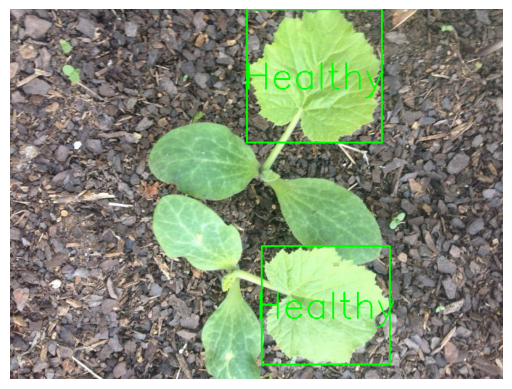

In [ ]:
import cv2
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the original image and resize it
new_width = 224
new_height = 224
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

original_image_path = '/content/drive/MyDrive/cucumber_project2/test_images/920e8abebbe58d237c48323a507af508.jpg'
original_image = cv2.imread(original_image_path)
output_image_filename = f"./output_image_{timestamp}.jpg"

# Preprocess the original image
# original_image = cv2.resize(original_image, (new_width, new_height))
# original_image = preprocess_input(original_image)

# Assuming you have already defined and loaded the model
results = YOLO_Model.predict(original_image)

H, W, D = original_image.shape
size_bounding_box = math.floor((H + W) * 0.002)

# Create an empty mask array to accumulate masks
all_masks = np.zeros((H, W), dtype=np.uint8)

for i, result in enumerate(results):
    if result.masks is not None:  # Check if masks are available
        for j, mask in enumerate(result.masks.data):
            mask = mask.numpy() * 255
            mask = cv2.resize(mask, (W, H))

            # Ensure that mask has the same data type as all_masks
            mask = mask.astype(np.uint8)

            # Accumulate the masks
            all_masks = cv2.add(all_masks, mask)
    else:
        # If masks are None, write the original image and stop processing
        cv2.imwrite(output_image_filename, original_image)
        break

# Generate a unique filename based on the current timestamp

segmented_filename = f"./segmented_image_{timestamp}.jpg"
cv2.imwrite(segmented_filename, all_masks)

# Load the segmented binary image and resize it
segmented_image = cv2.imread(segmented_filename, cv2.IMREAD_GRAYSCALE)

#Predict
input_image , all_contours_output, original_image_with_flash = remove_flash_reflections(original_image_path, segmented_filename)

leaf_predictions = []

for i, leaf in enumerate(original_image_with_flash, 1):
    process_image = cv2.cvtColor(leaf, cv2.COLOR_BGR2RGB)
    process_image = cv2.resize(leaf, (new_width, new_height))
    process_image = preprocess_input(process_image)

    print(CNN_Model.predict(np.expand_dims(process_image, axis=0)))
    predictions = np.squeeze(CNN_Model.predict(np.expand_dims(process_image, axis=0)) >= 0.5).astype(np.int)

    if predictions == 0:
        label = "Healthy"
    elif predictions == 1:
        label = "Unhealthy"
    else:
        label = "Unknown"

    leaf_predictions.append(label)

contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Set a minimum contour area threshold to filter out small contours (adjust as needed)
min_contour_area = 1000  # Adjust this value as needed

# Iterate through contours and add bounding boxes and labels to the original image
count_position_predict = 0
# Iterate through contours and add bounding boxes and labels to the original image
for contour in contours:
    # Calculate the contour area
    contour_area = cv2.contourArea(contour)

    # Filter out small contours (likely noise)
    if contour_area >= min_contour_area:
        # Calculate the bounding box
        x, y, w, h = cv2.boundingRect(contour)

        if len(leaf_predictions) > 0:
          label = leaf_predictions[count_position_predict-1]
          count_position_predict += 1

          print('count_position_predict', count_position_predict)
          if label == 'Unhealthy':
              font_color = (0, 0, 255)
              cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 0, 255), size_bounding_box)

          elif label == 'Healthy':
              font_color = (0, 255, 0)
              cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), size_bounding_box)

          else:
              font_color = (0, 0, 0)
              cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 0, 0), size_bounding_box)

          center_x = x + w // 2
          center_y = y + h // 2

          # Calculate the position for the label text
          label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, size_bounding_box, 1)
          label_x = center_x - label_size[0] // 2
          label_y = center_y + label_size[1] // 2
          font_thickness = size_bounding_box
          font = cv2.FONT_HERSHEY_SIMPLEX
          font_scale = size_bounding_box
          cv2.putText(original_image, label, (label_x, label_y), font, font_scale, font_color, font_thickness)

cv2.imwrite(output_image_filename, original_image)

plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



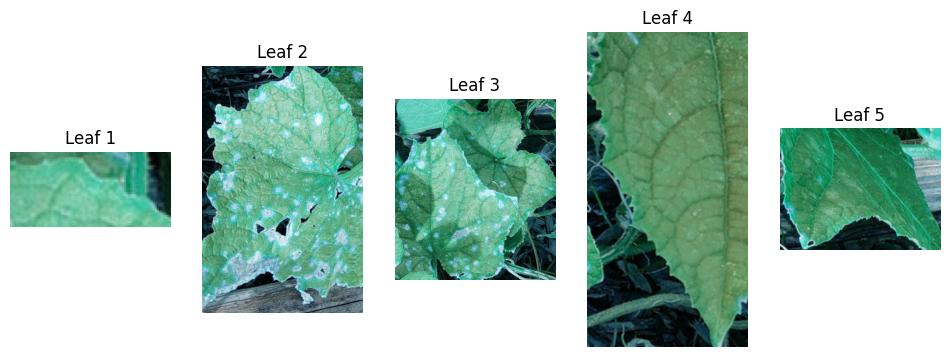

In [ ]:
plt.figure(figsize=(12, 6))
for i, image in enumerate(original_image_with_flash, 1):
        plt.subplot(1, len(original_image_with_flash), i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Leaf {i}')

plt.show()

In [ ]:
leaf_predictions

['Healthy', 'Healthy']

In [ ]:
len(cropped_leaves)

0

In [ ]:
len(processed_leaves)

196

In [ ]:
# Display the resized image
plt.subplot(1, 2, 2)
plt.title('Preprocessed Image')
plt.imshow(process_image[1])
plt.axis('off')

In [ ]:
for i, leaf in enumerate(cropped_leaves):
    process_image = cv2.resize(leaf, (new_height, new_width))
    process_image = np.expand_dims(process_image, axis=0)
    process_image = (process_image * 255).astype(np.uint8)  # Convert to uint8 and scale to [0, 255]

    # Convert BGR to RGB
    process_image_rgb = cv2.cvtColor(process_image[0], cv2.COLOR_BGR2RGB)

    # Display the resized image
    plt.subplot(1, 2, 2)
    plt.title('Preprocessed Image')
    plt.imshow(process_image_rgb)
    plt.axis('off')


In [ ]:
leaf

In [ ]:
process_image = cv2.resize(leaf, (new_height, new_width))
process_image

In [ ]:
original_image.shape

(3024, 4032, 3)

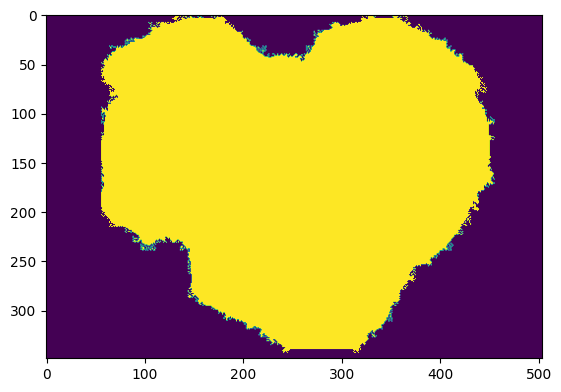

In [ ]:
plt.imshow((output_image) )

Number of processed leaves: 3


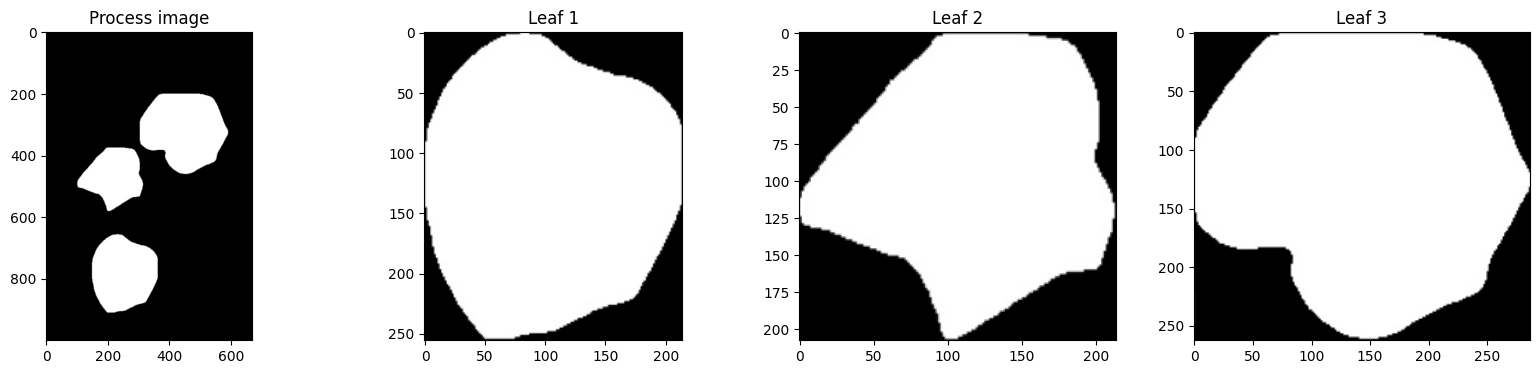

1/1 [==============================] - 0s 464ms/step


<ipython-input-13-51a90b15dae9>:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.squeeze(CNN_Model.predict(process_image) >= 0.5).astype(np.int)


1/1 [==============================] - 0s 228ms/step


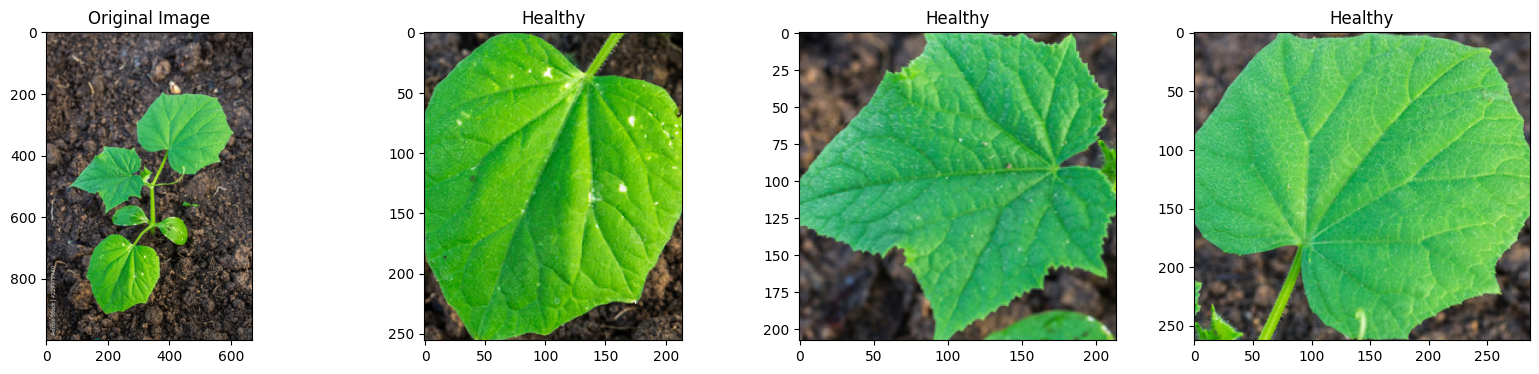

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize contours as a global variable
contours = None
new_width = 448
new_height = 448
# Function to remove flash reflections from a single image
def remove_flash_reflections(image_path):
    global contours  # Access the global contours variable
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define lower and upper color boundaries to filter flash reflections
    lower = [np.mean(image[:, :, i] - np.std(image[:, :, i]) / 3) for i in range(3)]
    upper = [250, 250, 250]

    # Create NumPy arrays from the boundaries
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # Find the colors within the specified boundaries and apply a mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)

    ret, thresh = cv2.threshold(mask, 40, 255, 0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    processed_leaves = []

    for i, contour in enumerate(contours, 1):
        # Get the bounding rectangle for the current contour
        x, y, w, h = cv2.boundingRect(contour)

        # Crop the leaf region from the original image
        leaf_extracted = image[y:y+h, x:x+w]

        # Add the cropped leaf to the list
        processed_leaves.append(leaf_extracted)

    return image, output, processed_leaves


image_path = '/content/drive/MyDrive/cucumber_project2/merged_masks.jpg'
original_image = cv2.imread("/content/drive/MyDrive/cucumber_project2/1000_F_229979960_J5BVDYhlDKWkiioB0mrakjIgXhBm1ceA.jpg")

input_image, all_contours_output, processed_leaves = remove_flash_reflections(image_path)

# Display the processed images
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1), plt.imshow(input_image), plt.title("Process image")
plt.subplot(1, 4, 2), plt.imshow(all_contours_output), plt.title("All Contours")

# Display each processed leaf separately
for i, leaf in enumerate(processed_leaves):
    plt.subplot(1, 4, i + 2)
    plt.imshow(leaf)
    plt.title(f"Leaf {i + 1}")

print("Number of processed leaves:", len(processed_leaves))
plt.show()

# Cut the original image using the positions of leaves from the binary image
cropped_leaves = []

for i, contour in enumerate(contours, 1):
    x, y, w, h = cv2.boundingRect(contour)
    leaf_cropped = original_image[y:y+h, x:x+w]
    cropped_leaves.append(leaf_cropped)

# Display the original image
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

leaf_predictions = []
# Display each cropped leaf
for i, leaf in enumerate(cropped_leaves):

    process_image = cv2.resize(leaf, (new_width, new_height))
    process_image = np.expand_dims(process_image, axis=0)
    process_image = preprocess_input(process_image)


    predictions = np.squeeze(CNN_Model.predict(process_image) >= 0.5).astype(np.int)

    if predictions == 0:
        label = "Healthy"
    elif predictions == 1:
        label = "Unhealthy"
    else:
        label = "Unknown"

    leaf_predictions.append(label)
    plt.subplot(1, 4, i + 2)
    plt.imshow(cv2.cvtColor(leaf, cv2.COLOR_BGR2RGB))
    plt.title(f"{label}")



plt.show()

